## SCAD, pytorch, variable selection

In [39]:
!pip install torch

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import scad_linear
from scaler_torch import StandardScaler, MinMaxScaler

In [41]:
device = torch.device('cpu')
dtype = torch.float64

## Part 1: SCAD class with real data
This section uses the <a href="https://archive.ics.uci.edu/dataset/165/concrete+compressive+strength">concrete.csv dataset</a> to predict linear correlations. The model is written using pytorch.

In [42]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [43]:
data = pd.read_csv('../data/concrete.csv')

x = data.drop(columns='strength').values
y = data['strength'].values

scaler = MinMaxScaler()
xscaled = scaler.fit_transform(x)

x_tensor = torch.tensor(xscaled, dtype= dtype)
y_tensor = torch.tensor(y, dtype= dtype)

In [44]:
model = scad_linear.SCADLinear(input_size= x_tensor.shape[1], lambda_val= 0.1, a_val= 2.5)

In [45]:
model.fit(x= torch.squeeze(x_tensor), y= y_tensor.unsqueeze(1), num_epochs= 1000, learning_rate= 0.09)
prediction = model.predict(x_tensor)

epoch: 100/1000, loss_with_scad: 147.17397513908486
epoch: 200/1000, loss_with_scad: 123.34516294289296
epoch: 300/1000, loss_with_scad: 115.89521999468293
epoch: 400/1000, loss_with_scad: 112.6888661171084
epoch: 500/1000, loss_with_scad: 110.99800295482748
epoch: 600/1000, loss_with_scad: 109.97103619670443
epoch: 700/1000, loss_with_scad: 109.2828818051641
epoch: 800/1000, loss_with_scad: 108.79149226671818
epoch: 900/1000, loss_with_scad: 108.4269991665843
epoch: 1000/1000, loss_with_scad: 108.15075291036258


In [46]:
mse(y_tensor, prediction)

108.14834742981772

In [47]:
model.get_coefficients()

Parameter containing:
tensor([[ 47.6363,  32.3547,  13.6079, -15.1883,  16.9288,   5.7865,   4.8199,
          40.0931]], dtype=torch.float64, requires_grad=True)

## Part 2: Strong Correlation Structure
Based on the simulation design explained in class, generate 200 data sets where the input features have a strong correlation structure (you may consider a 0.9) and apply ElasticNet, SqrtLasso and SCAD to check which method produces the best approximation of an ideal solution, such as a "betastar" you design with a sparsity pattern of your choice.

In [48]:
import numpy as np
from scipy.linalg import toeplitz
import models_for_comparison
import matplotlib.pyplot as plt

In [49]:
def make_correlated(num_samples, p, rho):
    vcor = []
    for i in range(p):
        vcor.append(rho**i)
    r = toeplitz(vcor)
    mu = np.repeat(0,p)
    x = np.random.multivariate_normal(mu, r, size=num_samples)
    return x

In [50]:
rho = 0.9
p = 6
n = 200
x = make_correlated(n, p, rho)
beta =np.array([-1,2,3,3,1,1])
beta = beta.reshape(-1,1)
betastar = np.concatenate([beta,np.repeat(0,p-len(beta)).reshape(-1,1)],axis=0)
y = x@betastar + 1.5*np.random.normal(size=(n,1))

x_tensor = torch.tensor(x, device=device)
y_tensor = torch.tensor(y, device= device)

In [51]:
scad = scad_linear.SCADLinear(x_tensor.shape[1], 0.5, 3)
elastic = models_for_comparison.ElasticNet(input_size=x_tensor.shape[1], alpha=0.1, l1_ratio=0.6)
sqrt = models_for_comparison.SqrtLasso(input_size= x_tensor.shape[1], alpha=0.1)

In [52]:
scad.fit(x_tensor, y_tensor, num_epochs=1000, learning_rate=0.01)
elastic.fit(x_tensor, y_tensor, num_epochs=1000, learning_rate=0.01)
sqrt.fit(x_tensor, y_tensor, num_epochs=1000, learning_rate= 0.01)

epoch: 100/1000, loss_with_scad: 3.4620186564703244
epoch: 200/1000, loss_with_scad: 2.860202880509245
epoch: 300/1000, loss_with_scad: 2.607241782637034
epoch: 400/1000, loss_with_scad: 2.4947756518458792
epoch: 500/1000, loss_with_scad: 2.4409783865286943
epoch: 600/1000, loss_with_scad: 2.4130153281014746
epoch: 700/1000, loss_with_scad: 2.3972538685947438
epoch: 800/1000, loss_with_scad: 2.387741589573737
epoch: 900/1000, loss_with_scad: 2.3816983865705184
epoch: 1000/1000, loss_with_scad: 2.3777188183012647
Epoch [100/1000], Loss: 2.871156750672027
Epoch [200/1000], Loss: 2.614525981713017
Epoch [300/1000], Loss: 2.4659390909833006
Epoch [400/1000], Loss: 2.378916814618398
Epoch [500/1000], Loss: 2.3477898922256593
Epoch [600/1000], Loss: 2.3321884293935926
Epoch [700/1000], Loss: 2.3228511287086056
Epoch [800/1000], Loss: 2.3171099442112837
Epoch [900/1000], Loss: 2.3134866461404187
Epoch [1000/1000], Loss: 2.311137520038411
Epoch [100/1000], Loss: 5.6949516454843705
Epoch [200/1

In [53]:
coefficients = {'Original coefficients': betastar.flatten(),
                'SCADLinear': scad.get_coefficients().detach().numpy().flatten(),
                'SqrtLasso': sqrt.get_coefficients().detach().numpy().flatten(),
                'ElasticNet': elastic.get_coefficients().detach().numpy().flatten()}
coef = pd.DataFrame(coefficients)
pd.set_option('display.float_format', '{:,.4f}'.format)

for model in [scad, elastic, sqrt]:
    score = mse(y_tensor.detach().numpy(), model.predict(x_tensor).detach().numpy())
    print(f'model: {model}\nscore: {score}')

model: SCADLinear(
  (linear): Linear(in_features=6, out_features=1, bias=False)
)
score: 2.377686506413536
model: ElasticNet(
  (linear): Linear(in_features=6, out_features=1, bias=False)
)
score: 2.6438647065478484
model: SqrtLasso(
  (linear): Linear(in_features=6, out_features=1, bias=False)
)
score: 2.721645153871475


C:\Users\romer\AppData\Local\Temp\ipykernel_19072\3403489170.py:3: UserWarning: The handle <BarContainer object of 6 artists> has a label of '_Original coefficients' which cannot be automatically added to the legend.
  plt.legend(['_Original coefficients', 'SCADLinear', 'SqrtLasso', 'ElasticNet'])


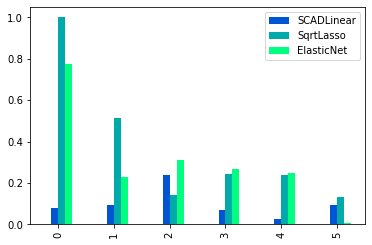

In [54]:
absolute_difference = coef.sub(coef['Original coefficients'], axis=0).abs()
absolute_difference.plot(kind='bar', colormap='winter')
plt.legend(['_Original coefficients', 'SCADLinear', 'SqrtLasso', 'ElasticNet'])

## Part 3: Concrete Dataset
Use the methods you implemented above to determine a variable selection for the Concrete data set with quadratic interaction terms (polynomial features of degree 2). To solve this, you should consider choosing the best weight for the penalty function. What is the ideal model size (number of variables with non-zero weights), and what is the cross-validated mean square error?

In [55]:
from sklearn.preprocessing import PolynomialFeatures

In [56]:
data = pd.read_csv('../data/concrete.csv')

x = data.drop(columns='strength').values
y = data['strength'].values

polynomial = PolynomialFeatures(degree=2, include_bias=False)
x_polynomial = polynomial.fit_transform(x)
scaler = MinMaxScaler()
xscaled = scaler.fit_transform(x_polynomial)

x_tensor = torch.tensor(xscaled, dtype= dtype)
y_tensor = torch.tensor(y, dtype= dtype)

In [58]:
model = scad_linear.SCADLinear(input_size=x_tensor.shape[1], lambda_val= 0.1, a_val= 3)

In [62]:
model.fit(x_tensor, y_tensor.unsqueeze(1), num_epochs = 1000, learning_rate = 0.09)

epoch: 100/1000, loss_with_scad: 99.77343893017353
epoch: 200/1000, loss_with_scad: 88.97741089791268
epoch: 300/1000, loss_with_scad: 83.5771587373276
epoch: 400/1000, loss_with_scad: 80.24529724147183
epoch: 500/1000, loss_with_scad: 77.89828988385767
epoch: 600/1000, loss_with_scad: 76.08903290094109
epoch: 700/1000, loss_with_scad: 74.6096178346613
epoch: 800/1000, loss_with_scad: 73.35312443718502
epoch: 900/1000, loss_with_scad: 72.25953402641053
epoch: 1000/1000, loss_with_scad: 71.29235870610395
